# 1. Set up

In [1]:
!pip install neo4j
!pip install torch
!pip install torch_geometric

# 2. Import necessary libraries

In [ ]:
import torch
from torch_geometric.data import HeteroData
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
import warnings
import logging
from datetime import datetime, timedelta
import random

In [3]:
warnings.filterwarnings('ignore')

In [ ]:
from config import *

# 3. Define global variables

In [5]:
URI = "bolt://localhost:7687"
USERNAME = "neo4j"
PASSWORD = "password"

# 4. Functions

In [19]:
def plot_heterogeneous_results(history, test_results, attention_analysis):
    """Visualiza resultados del modelo heterogéneo"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Historial de entrenamiento
    axes[0, 0].plot(history['train_losses'], label='Train Loss', alpha=0.7)
    axes[0, 0].plot(history['val_losses'], label='Val Loss', alpha=0.7)
    axes[0, 0].set_title('Pérdida durante el entrenamiento')
    axes[0, 0].set_xlabel('Época')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(history['train_accuracies'], label='Train Accuracy', alpha=0.7)
    axes[0, 1].plot(history['val_accuracies'], label='Val Accuracy', alpha=0.7)
    axes[0, 1].set_title('Precisión durante el entrenamiento')
    axes[0, 1].set_xlabel('Época')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 2. Matriz de confusión
    sns.heatmap(test_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Fraude', 'Irregularidad'],
                yticklabels=['Normal', 'Fraude', 'Irregularidad'], ax=axes[1, 0])
    axes[1, 0].set_title('Matriz de Confusión')
    axes[1, 0].set_xlabel('Predicción')
    axes[1, 0].set_ylabel('Verdadero')
    
    # 3. Pesos de atención
    info_types = list(attention_analysis.keys())
    weights = list(attention_analysis.values())
    
    bars = axes[1, 1].bar(range(len(info_types)), weights, alpha=0.7, color='skyblue')
    axes[1, 1].set_title('Pesos de Atención por Tipo de Información')
    axes[1, 1].set_xlabel('Tipo de Información')
    axes[1, 1].set_ylabel('Peso de Atención')
    axes[1, 1].set_xticks(range(len(info_types)))
    axes[1, 1].set_xticklabels(info_types, rotation=45, ha='right')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Añadir valores en las barras
    for bar, weight in zip(bars, weights):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{weight:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# 5. Code

## 5.2. Simulador de datos

In [ ]:
# ==========================================
# 2. SIMULADOR DE DATOS HETEROGÉNEOS
# ==========================================

class HeterogeneousDataSimulator:
    """Simulador de datos para grafo heterogéneo complejo"""
    
    def __init__(self):
        np.random.seed(RANDOM_SEED)
        random.seed(RANDOM_SEED)
        
    def generate_heterogeneous_data(self) -> Dict:
        """Genera dataset heterogéneo completo"""
        
        print("🎲 Generando datos heterogéneos complejos...")
        
        # Generar nodos de cada tipo
        node_data = {
            'contador': self._generate_contador_nodes(),
            'suministro': self._generate_suministro_nodes(),
            'comercializadora': self._generate_comercializadora_nodes(),
            'ubicacion': self._generate_ubicacion_nodes(),
            'concentrador': self._generate_concentrador_nodes(),
            'cliente': self._generate_cliente_nodes(),
            'transformador': self._generate_transformador_nodes(),
            'zona': self._generate_zona_nodes()
        }
        
        # Generar relaciones heterogéneas
        edge_data = self._generate_heterogeneous_edges(node_data)
        
        # Asignar etiquetas de fraude (solo a contadores)
        node_data['contador'] = self._assign_fraud_labels(node_data['contador'])
        
        print(f"✅ Generados {sum(len(nodes) for nodes in node_data.values())} nodos")
        print(f"✅ Generadas {sum(len(edges) for edges in edge_data.values())} relaciones")
        
        return {
            'nodes': node_data,
            'edges': edge_data
        }
    
    def _generate_contador_nodes(self) -> pd.DataFrame:
        """Genera nodos de contadores con características detalladas"""
        
        data = {
            'node_id': [f"CNT_{i:06d}" for i in range(NUM_CONTADORES_ADV)],
            
            # Características técnicas
            'marca': np.random.choice(['LANDIS', 'ITRON', 'CIRCUTOR', 'SCHNEIDER', 'ABB'], NUM_CONTADORES_ADV),
            'modelo': np.random.choice(['E350', 'E450', 'A1140', 'A1800', 'B23'], NUM_CONTADORES_ADV),
            'tipo_aparato': np.random.choice(['ELECTRONICO', 'ELECTROMECANICO', 'HIBRIDO'], 
                                           NUM_CONTADORES_ADV, p=[0.7, 0.2, 0.1]),
            'numero_serie': [f"SN{random.randint(100000, 999999)}" for _ in range(NUM_CONTADORES_ADV)],
            'fecha_fabricacion': pd.to_datetime([
                datetime.now() - timedelta(days=random.randint(30, 3650)) 
                for _ in range(NUM_CONTADORES_ADV)
            ]),
            'fecha_instalacion': pd.to_datetime([
                datetime.now() - timedelta(days=random.randint(1, 1825)) 
                for _ in range(NUM_CONTADORES_ADV)
            ]),
            
            # Características eléctricas
            'potencia_maxima': np.random.lognormal(8.5, 0.8, NUM_CONTADORES_ADV),
            'tension_nominal': np.random.choice([230, 400], NUM_CONTADORES_ADV, p=[0.6, 0.4]),
            'fases': np.random.choice([1, 3], NUM_CONTADORES_ADV, p=[0.7, 0.3]),
            'clase_precision': np.random.choice([1, 2, 0.5], NUM_CONTADORES_ADV, p=[0.6, 0.3, 0.1]),
            'intensidad_maxima': np.random.lognormal(3.0, 0.5, NUM_CONTADORES_ADV),
            
            # Telegestión y comunicaciones
            'telegest_activo': np.random.choice([True, False], NUM_CONTADORES_ADV, p=[0.85, 0.15]),
            'protocolo_comunicacion': np.random.choice(['PLC', 'RF', 'GPRS', 'ETHERNET'], 
                                                     NUM_CONTADORES_ADV, p=[0.4, 0.3, 0.2, 0.1]),
            'version_firmware': [f"v{random.randint(1,5)}.{random.randint(0,9)}.{random.randint(0,9)}" 
                               for _ in range(NUM_CONTADORES_ADV)],
            'estado_comunicacion': np.random.choice(['ACTIVO', 'INTERMITENTE', 'PERDIDO'], 
                                                  NUM_CONTADORES_ADV, p=[0.8, 0.15, 0.05]),
            
            # Métricas operacionales
            'dias_desde_instalacion': [(datetime.now() - pd.to_datetime([
                datetime.now() - timedelta(days=random.randint(1, 1825)) 
                for _ in range(NUM_CONTADORES_ADV)
            ])[i]).days for i in range(NUM_CONTADORES_ADV)],
            'num_reinicios': np.random.poisson(2, NUM_CONTADORES_ADV),
            'eventos_alarma': np.random.poisson(1, NUM_CONTADORES_ADV),
            'calidad_senal': np.random.beta(8, 2, NUM_CONTADORES_ADV) * 100,
            
            # Consumo y patrones
            'consumo_promedio_diario': np.random.lognormal(3.5, 1.2, NUM_CONTADORES_ADV),
            'consumo_maximo_registrado': np.random.lognormal(4.0, 1.0, NUM_CONTADORES_ADV),
            'consumo_minimo_registrado': np.random.exponential(5, NUM_CONTADORES_ADV),
            'variabilidad_consumo': np.random.exponential(20, NUM_CONTADORES_ADV),
            'patron_horario': np.random.choice(['RESIDENCIAL', 'COMERCIAL', 'INDUSTRIAL'], 
                                             NUM_CONTADORES_ADV, p=[0.6, 0.3, 0.1]),
            'dias_sin_consumo': np.random.poisson(3, NUM_CONTADORES_ADV),
            'picos_consumo_anormales': np.random.poisson(0.5, NUM_CONTADORES_ADV),
            
            # Mantenimiento y incidencias
            'ultima_inspeccion': pd.to_datetime([
                datetime.now() - timedelta(days=random.randint(0, 730)) 
                for _ in range(NUM_CONTADORES_ADV)
            ]),
            'resultado_ultima_inspeccion': np.random.choice(['CORRECTO', 'ANOMALIA_MENOR', 'ANOMALIA_MAYOR'], 
                                                          NUM_CONTADORES_ADV, p=[0.85, 0.12, 0.03]),
            'num_averias': np.random.poisson(0.3, NUM_CONTADORES_ADV),
            'dias_fuera_servicio': np.random.poisson(1, NUM_CONTADORES_ADV),
            
            # Indicadores de riesgo
            'score_fiabilidad': np.random.beta(7, 3, NUM_CONTADORES_ADV) * 100,
            'anomalias_detectadas': np.random.poisson(0.8, NUM_CONTADORES_ADV),
            'tendencia_consumo': np.random.choice(['ESTABLE', 'CRECIENTE', 'DECRECIENTE'], 
                                                NUM_CONTADORES_ADV, p=[0.7, 0.2, 0.1])
        }
        
        return pd.DataFrame(data)
    
    def _generate_suministro_nodes(self) -> pd.DataFrame:
        """Genera nodos de suministros/contratos"""
        
        data = {
            'node_id': [f"SUM_{i:06d}" for i in range(NUM_SUMINISTROS_ADV)],
            
            # Datos contractuales
            'fecha_alta': pd.to_datetime([
                datetime.now() - timedelta(days=random.randint(1, 2555)) 
                for _ in range(NUM_SUMINISTROS_ADV)
            ]),
            'fecha_baja': pd.to_datetime([
                datetime.now() + timedelta(days=random.randint(-30, 365)) if random.random() < 0.05 else None
                for _ in range(NUM_SUMINISTROS_ADV)
            ]),
            'estado_contrato': np.random.choice(['ACTIVO', 'SUSPENDIDO', 'BAJA'], 
                                              NUM_SUMINISTROS_ADV, p=[0.92, 0.05, 0.03]),
            'tipo_suministro': np.random.choice(['RESIDENCIAL', 'COMERCIAL', 'INDUSTRIAL', 'AGRICOLA'], 
                                              NUM_SUMINISTROS_ADV, p=[0.6, 0.25, 0.1, 0.05]),
            
            # Potencia y tarifa
            'potencia_contratada': np.random.lognormal(8.0, 1.0, NUM_SUMINISTROS_ADV),
            'potencia_maxima_demandada': np.random.lognormal(8.2, 0.8, NUM_SUMINISTROS_ADV),
            'tarifa_activa': np.random.choice(['2.0TD', '3.0TD', '6.1TD', '6.2TD'], 
                                            NUM_SUMINISTROS_ADV, p=[0.7, 0.2, 0.05, 0.05]),
            'discriminacion_horaria': np.random.choice([True, False], NUM_SUMINISTROS_ADV, p=[0.4, 0.6]),
            
            # CNAE y actividad
            'cnae': np.random.choice(['4711', '5210', '9820', '1071', '4540'], 
                                   NUM_SUMINISTROS_ADV, p=[0.3, 0.25, 0.2, 0.15, 0.1]),
            'actividad_declarada': np.random.choice(['VIVIENDA', 'COMERCIO', 'OFICINA', 'INDUSTRIA', 'OTROS'], 
                                                  NUM_SUMINISTROS_ADV, p=[0.6, 0.2, 0.1, 0.05, 0.05]),
            
            # Facturación y pagos
            'facturacion_mensual_promedio': np.random.lognormal(4.5, 1.0, NUM_SUMINISTROS_ADV),
            'dias_morosidad': np.random.exponential(5, NUM_SUMINISTROS_ADV),
            'num_impagos': np.random.poisson(0.2, NUM_SUMINISTROS_ADV),
            'metodo_pago': np.random.choice(['DOMICILIACION', 'TRANSFERENCIA', 'EFECTIVO'], 
                                          NUM_SUMINISTROS_ADV, p=[0.8, 0.15, 0.05]),
            
            # Consumo contractual
            'consumo_anual_estimado': np.random.lognormal(7.0, 1.2, NUM_SUMINISTROS_ADV),
            'consumo_anual_real': np.random.lognormal(7.1, 1.1, NUM_SUMINISTROS_ADV),
            'desviacion_consumo_estimado': np.random.normal(0, 25, NUM_SUMINISTROS_ADV),
            
            # Modificaciones contractuales
            'num_cambios_potencia': np.random.poisson(0.3, NUM_SUMINISTROS_ADV),
            'num_cambios_tarifa': np.random.poisson(0.2, NUM_SUMINISTROS_ADV),
            'ultima_modificacion': pd.to_datetime([
                datetime.now() - timedelta(days=random.randint(30, 730)) if random.random() < 0.3 else None
                for _ in range(NUM_SUMINISTROS_ADV)
            ])
        }
        
        return pd.DataFrame(data)
    
    def _generate_comercializadora_nodes(self) -> pd.DataFrame:
        """Genera nodos de comercializadoras"""
        
        nombres = ['ENDESA', 'IBERDROLA', 'NATURGY', 'VIESGO', 'EDP', 'HOLALUZ', 'FACTOR', 'LUCERA', 
                  'PEPEENERGY', 'SOMA', 'BASER', 'ALDRO', 'REPSOL', 'TOTALENERGIES', 'GALP', 
                  'GESTERNOVA', 'NEXUS', 'ACCIONA', 'CIDE', 'COMPETENCIA']
        
        data = {
            'node_id': [f"COM_{i:03d}" for i in range(NUM_COMERCIALIZADORAS_ADV)],
            'nombre': nombres[:NUM_COMERCIALIZADORAS_ADV],
            'tipo_empresa': np.random.choice(['GRAN_EMPRESA', 'MEDIANA_EMPRESA', 'STARTUP'], 
                                           NUM_COMERCIALIZADORAS_ADV, p=[0.6, 0.3, 0.1]),
            'NUM_CLIENTES_ADV_total': np.random.lognormal(10, 2, NUM_COMERCIALIZADORAS_ADV),
            'cuota_mercado': np.random.exponential(5, NUM_COMERCIALIZADORAS_ADV),
            'anos_operando': np.random.randint(1, 25, NUM_COMERCIALIZADORAS_ADV),
            'rating_financiero': np.random.choice(['AAA', 'AA', 'A', 'BBB', 'BB'], 
                                                NUM_COMERCIALIZADORAS_ADV, p=[0.1, 0.2, 0.4, 0.2, 0.1]),
            'num_reclamaciones': np.random.poisson(50, NUM_COMERCIALIZADORAS_ADV),
            'tiempo_respuesta_promedio': np.random.exponential(3, NUM_COMERCIALIZADORAS_ADV),
            'score_satisfaccion': np.random.beta(6, 2, NUM_COMERCIALIZADORAS_ADV) * 10,
            'precios_competitivos': np.random.beta(5, 3, NUM_COMERCIALIZADORAS_ADV),
            'productos_verdes': np.random.choice([True, False], NUM_COMERCIALIZADORAS_ADV, p=[0.7, 0.3]),
            'servicios_digitales': np.random.choice([True, False], NUM_COMERCIALIZADORAS_ADV, p=[0.8, 0.2])
        }
        
        return pd.DataFrame(data)
    
    def _generate_ubicacion_nodes(self) -> pd.DataFrame:
        """Genera nodos de ubicaciones geográficas"""
        
        # Simular coordenadas en España
        lat_base, lon_base = 40.4168, -3.7038  # Madrid centro
        
        data = {
            'node_id': [f"UBI_{i:06d}" for i in range(NUM_UBICACIONES_ADV)],
            'latitud': np.random.normal(lat_base, 2.5, NUM_UBICACIONES_ADV),
            'longitud': np.random.normal(lon_base, 3.0, NUM_UBICACIONES_ADV),
            'coordenada_utm_x': np.random.uniform(300000, 800000, NUM_UBICACIONES_ADV),
            'coordenada_utm_y': np.random.uniform(4200000, 4800000, NUM_UBICACIONES_ADV),
            'codigo_postal': [f"{random.randint(1, 52):02d}{random.randint(1, 999):03d}" 
                            for _ in range(NUM_UBICACIONES_ADV)],
            'provincia': np.random.choice(['MADRID', 'BARCELONA', 'VALENCIA', 'SEVILLA', 'BILBAO', 'ZARAGOZA'], 
                                       NUM_UBICACIONES_ADV, p=[0.3, 0.25, 0.15, 0.1, 0.1, 0.1]),
            'tipo_zona': np.random.choice(['URBANA', 'RURAL', 'SEMIURBANA'], 
                                        NUM_UBICACIONES_ADV, p=[0.6, 0.2, 0.2]),
            'densidad_poblacion': np.random.lognormal(6, 1.5, NUM_UBICACIONES_ADV),
            'nivel_socioeconomico': np.random.choice(['ALTO', 'MEDIO_ALTO', 'MEDIO', 'MEDIO_BAJO', 'BAJO'], 
                                                   NUM_UBICACIONES_ADV, p=[0.1, 0.2, 0.4, 0.2, 0.1]),
            'indice_criminalidad': np.random.exponential(3, NUM_UBICACIONES_ADV),
            'accesibilidad_tecnica': np.random.choice(['FACIL', 'NORMAL', 'DIFICIL'], 
                                                    NUM_UBICACIONES_ADV, p=[0.6, 0.3, 0.1]),
            'cobertura_comunicaciones': np.random.beta(8, 2, NUM_UBICACIONES_ADV) * 100,
            'historial_fraudes': np.random.poisson(0.5, NUM_UBICACIONES_ADV),
            'NUM_CONTADORES_ADV_zona': np.random.poisson(10, NUM_UBICACIONES_ADV),
            'distancia_centro_transformacion': np.random.exponential(500, NUM_UBICACIONES_ADV),
            'calidad_suministro': np.random.beta(9, 1, NUM_UBICACIONES_ADV) * 100
        }
        
        return pd.DataFrame(data)
    
    def _generate_concentrador_nodes(self) -> pd.DataFrame:
        """Genera nodos de concentradores de comunicaciones"""
        
        data = {
            'node_id': [f"CON_{i:04d}" for i in range(NUM_CONCENTRADORES_ADV)],
            'fabricante': np.random.choice(['ZIV', 'SAGITTARIUS', 'PRIME', 'LANDIS', 'ITRON'], 
                                         NUM_CONCENTRADORES_ADV),
            'modelo_concentrador': np.random.choice(['DCU_500', 'DCU_1000', 'PRIME_Master', 'G3_Head'], 
                                                  NUM_CONCENTRADORES_ADV),
            'version_software': [f"v{random.randint(2,6)}.{random.randint(0,9)}" 
                               for _ in range(NUM_CONCENTRADORES_ADV)],
            'capacidad_maxima': np.random.choice([500, 1000, 2000, 5000], NUM_CONCENTRADORES_ADV),
            'contadores_conectados': np.random.randint(10, 500, NUM_CONCENTRADORES_ADV),
            'tasa_lectura_exitosa': np.random.beta(9, 1, NUM_CONCENTRADORES_ADV) * 100,
            'latencia_promedio': np.random.exponential(2, NUM_CONCENTRADORES_ADV),
            'uptime_porcentaje': np.random.beta(95, 5, NUM_CONCENTRADORES_ADV) * 100,
            'num_reinicios_mes': np.random.poisson(1, NUM_CONCENTRADORES_ADV),
            'errores_comunicacion': np.random.poisson(5, NUM_CONCENTRADORES_ADV),
            'temperatura_operacion': np.random.normal(35, 10, NUM_CONCENTRADORES_ADV),
            'nivel_bateria': np.random.beta(8, 2, NUM_CONCENTRADORES_ADV) * 100,
            'calidad_senal_red': np.random.beta(7, 3, NUM_CONCENTRADORES_ADV) * 100,
            'protocolo_principal': np.random.choice(['PLC_PRIME', 'PLC_G3', 'RF_169MHz', 'GPRS'], 
                                                  NUM_CONCENTRADORES_ADV, p=[0.4, 0.3, 0.2, 0.1]),
            'backup_comunicacion': np.random.choice([True, False], NUM_CONCENTRADORES_ADV, p=[0.7, 0.3]),
            'ultima_actualizacion': pd.to_datetime([
                datetime.now() - timedelta(days=random.randint(1, 365)) 
                for _ in range(NUM_CONCENTRADORES_ADV)
            ])
        }
        
        return pd.DataFrame(data)
    
    def _generate_cliente_nodes(self) -> pd.DataFrame:
        """Genera nodos de clientes"""
        
        data = {
            'node_id': [f"CLI_{i:06d}" for i in range(NUM_CLIENTES_ADV)],
            'tipo_cliente': np.random.choice(['PERSONA_FISICA', 'PERSONA_JURIDICA', 'ADMINISTRACION'], 
                                           NUM_CLIENTES_ADV, p=[0.8, 0.15, 0.05]),
            'antiguedad_cliente': np.random.exponential(5, NUM_CLIENTES_ADV),
            'NUM_SUMINISTROS_ADV': np.random.choice([1, 2, 3, 4, 5], NUM_CLIENTES_ADV, p=[0.7, 0.2, 0.05, 0.03, 0.02]),
            'score_crediticio': np.random.beta(6, 4, NUM_CLIENTES_ADV) * 1000,
            'ingresos_declarados': np.random.lognormal(10, 0.8, NUM_CLIENTES_ADV),
            'edad_estimada': np.random.normal(45, 15, NUM_CLIENTES_ADV),
            'canal_preferido': np.random.choice(['ONLINE', 'TELEFONO', 'PRESENCIAL', 'EMAIL'], 
                                              NUM_CLIENTES_ADV, p=[0.4, 0.3, 0.2, 0.1]),
            'num_reclamaciones': np.random.poisson(0.5, NUM_CLIENTES_ADV),
            'num_cambios_comercializadora': np.random.poisson(1, NUM_CLIENTES_ADV),
            'satisfaccion_cliente': np.random.beta(7, 3, NUM_CLIENTES_ADV) * 10,
            'uso_servicios_digitales': np.random.choice([True, False], NUM_CLIENTES_ADV, p=[0.6, 0.4]),
            'conciencia_energetica': np.random.beta(5, 5, NUM_CLIENTES_ADV) * 10,
            'historial_impagos': np.random.poisson(0.3, NUM_CLIENTES_ADV),
            'metodo_contacto_preferido': np.random.choice(['EMAIL', 'SMS', 'CARTA', 'TELEFONO'], 
                                                        NUM_CLIENTES_ADV, p=[0.5, 0.3, 0.1, 0.1]),
            'programa_fidelizacion': np.random.choice([True, False], NUM_CLIENTES_ADV, p=[0.3, 0.7])
        }
        
        return pd.DataFrame(data)
    
    def _generate_transformador_nodes(self) -> pd.DataFrame:
        """Genera nodos de transformadores de distribución"""
        
        data = {
            'node_id': [f"TRF_{i:04d}" for i in range(NUM_TRANSFORMADORES_ADV)],
            'potencia_nominal': np.random.choice([25, 50, 100, 160, 250, 400, 630], 
                                               NUM_TRANSFORMADORES_ADV, p=[0.1, 0.2, 0.25, 0.2, 0.15, 0.08, 0.02]),
            'tension_primaria': np.random.choice([15000, 20000, 25000], NUM_TRANSFORMADORES_ADV, p=[0.4, 0.4, 0.2]),
            'tension_secundaria': np.random.choice([400, 230], NUM_TRANSFORMADORES_ADV, p=[0.7, 0.3]),
            'año_fabricacion': np.random.randint(1980, 2024, NUM_TRANSFORMADORES_ADV),
            'fabricante_transformador': np.random.choice(['SCHNEIDER', 'ABB', 'SIEMENS', 'ORMAZABAL', 'COOPER'], 
                                                       NUM_TRANSFORMADORES_ADV),
            'tipo_refrigeracion': np.random.choice(['ACEITE', 'SECO', 'SILICONA'], 
                                                 NUM_TRANSFORMADORES_ADV, p=[0.6, 0.3, 0.1]),
            'carga_actual_porcentaje': np.random.beta(6, 4, NUM_TRANSFORMADORES_ADV) * 100,
            'carga_maxima_historica': np.random.beta(8, 2, NUM_TRANSFORMADORES_ADV) * 100,
            'temperatura_operacion': np.random.normal(45, 15, NUM_TRANSFORMADORES_ADV),
            'NUM_CONTADORES_ADV_alimentados': np.random.poisson(30, NUM_TRANSFORMADORES_ADV),
            'perdidas_tecnicas': np.random.beta(2, 8, NUM_TRANSFORMADORES_ADV) * 5,
            'ultima_revision': pd.to_datetime([
                datetime.now() - timedelta(days=random.randint(30, 1095)) 
                for _ in range(NUM_TRANSFORMADORES_ADV)
            ]),
            'estado_conservacion': np.random.choice(['EXCELENTE', 'BUENO', 'REGULAR', 'MALO'], 
                                                  NUM_TRANSFORMADORES_ADV, p=[0.2, 0.5, 0.25, 0.05]),
            'num_averias': np.random.poisson(0.5, NUM_TRANSFORMADORES_ADV),
            'tiempo_fuera_servicio': np.random.exponential(2, NUM_TRANSFORMADORES_ADV),
            'monitorizacion_remota': np.random.choice([True, False], NUM_TRANSFORMADORES_ADV, p=[0.4, 0.6]),
            'sistema_proteccion': np.random.choice(['FUSIBLES', 'INTERRUPTOR', 'AUTOMATICO'], 
                                                 NUM_TRANSFORMADORES_ADV, p=[0.3, 0.4, 0.3])
        }
        
        return pd.DataFrame(data)
    
    def _generate_zona_nodes(self) -> pd.DataFrame:
        """Genera nodos de zonas de distribución"""
        
        data = {
            'node_id': [f"ZON_{i:03d}" for i in range(NUM_ZONAS_ADV)],
            'nombre_zona': [f"ZONA_{chr(65 + i//26)}{i%26 + 1}" for i in range(NUM_ZONAS_ADV)],
            'tipo_zona_electrica': np.random.choice(['URBANA_DENSA', 'URBANA', 'RURAL', 'INDUSTRIAL'], 
                                                  NUM_ZONAS_ADV, p=[0.2, 0.4, 0.3, 0.1]),
            'NUM_TRANSFORMADORES_ADV': np.random.poisson(8, NUM_ZONAS_ADV),
            'NUM_CONTADORES_ADV_zona': np.random.poisson(200, NUM_ZONAS_ADV),
            'longitud_red_mt': np.random.exponential(10, NUM_ZONAS_ADV),  # km
            'longitud_red_bt': np.random.exponential(25, NUM_ZONAS_ADV),  # km
            'indice_calidad_suministro': np.random.beta(8, 2, NUM_ZONAS_ADV) * 10,
            'tiempo_medio_interrupcion': np.random.exponential(2, NUM_ZONAS_ADV),  # horas/año
            'perdidas_tecnicas_zona': np.random.beta(3, 7, NUM_ZONAS_ADV) * 10,  # %
            'perdidas_no_tecnicas': np.random.exponential(2, NUM_ZONAS_ADV),  # %
            'densidad_carga': np.random.lognormal(3, 1, NUM_ZONAS_ADV),  # MW/km²
            'crecimiento_demanda': np.random.normal(2, 1, NUM_ZONAS_ADV),  # %/año
            'num_incidencias_mes': np.random.poisson(3, NUM_ZONAS_ADV),
            'cobertura_telemedida': np.random.beta(8, 2, NUM_ZONAS_ADV) * 100,  # %
            'antiguedad_red_promedio': np.random.normal(25, 10, NUM_ZONAS_ADV),  # años
            'inversion_mantenimiento': np.random.lognormal(8, 1, NUM_ZONAS_ADV),  # €/año
            'personal_tecnico_asignado': np.random.poisson(2, NUM_ZONAS_ADV),
            'vehiculos_disponibles': np.random.poisson(1, NUM_ZONAS_ADV),
            'almacen_material': np.random.choice([True, False], NUM_ZONAS_ADV, p=[0.6, 0.4])
        }
        
        return pd.DataFrame(data)
    
    def _generate_heterogeneous_edges(self, node_data: Dict) -> Dict:
        """Genera todas las relaciones heterogéneas entre tipos de nodos"""
        
        print("🔗 Generando relaciones heterogéneas...")
        
        edge_data = {}
        
        # 1. CONTADOR -> SUMINISTRO (1:1)
        edge_data[('contador', 'mide', 'suministro')] = self._create_contador_suministro_edges(
            node_data['contador'], node_data['suministro']
        )
        
        # 2. SUMINISTRO -> COMERCIALIZADORA (N:1)
        edge_data[('suministro', 'contratado_con', 'comercializadora')] = self._create_suministro_comercializadora_edges(
            node_data['suministro'], node_data['comercializadora']
        )
        
        # 3. CONTADOR -> UBICACION (N:1)
        edge_data[('contador', 'ubicado_en', 'ubicacion')] = self._create_contador_ubicacion_edges(
            node_data['contador'], node_data['ubicacion']
        )
        
        # 4. CONTADOR -> CONCENTRADOR (N:1)
        edge_data[('contador', 'comunica_via', 'concentrador')] = self._create_contador_concentrador_edges(
            node_data['contador'], node_data['concentrador']
        )
        
        # 5. SUMINISTRO -> CLIENTE (N:1)
        edge_data[('suministro', 'pertenece_a', 'cliente')] = self._create_suministro_cliente_edges(
            node_data['suministro'], node_data['cliente']
        )
        
        # 6. CONTADOR -> TRANSFORMADOR (N:1)
        edge_data[('contador', 'alimentado_por', 'transformador')] = self._create_contador_transformador_edges(
            node_data['contador'], node_data['transformador']
        )
        
        # 7. TRANSFORMADOR -> ZONA (N:1)
        edge_data[('transformador', 'pertenece_zona', 'zona')] = self._create_transformador_zona_edges(
            node_data['transformador'], node_data['zona']
        )
        
        # 8. UBICACION -> ZONA (N:1)
        edge_data[('ubicacion', 'dentro_de', 'zona')] = self._create_ubicacion_zona_edges(
            node_data['ubicacion'], node_data['zona']
        )
        
        # 9. Relaciones intra-tipo
        
        # CONTADOR -> CONTADOR (proximidad geográfica)
        edge_data[('contador', 'cerca_de', 'contador')] = self._create_contador_contador_edges(
            node_data['contador'], node_data['ubicacion']
        )
        
        # CONTADOR -> CONTADOR (mismo modelo/marca)
        edge_data[('contador', 'similar_a', 'contador')] = self._create_contador_similar_edges(
            node_data['contador']
        )
        
        # TRANSFORMADOR -> TRANSFORMADOR (misma zona)
        edge_data[('transformador', 'conectado_a', 'transformador')] = self._create_transformador_transformador_edges(
            node_data['transformador']
        )
        
        # CLIENTE -> CLIENTE (múltiples suministros)
        edge_data[('cliente', 'relacionado_con', 'cliente')] = self._create_cliente_cliente_edges(
            node_data['cliente']
        )
        
        return edge_data
    
    def _create_contador_suministro_edges(self, contadores: pd.DataFrame, suministros: pd.DataFrame) -> List:
        """Relación 1:1 entre contadores y suministros"""
        edges = []
        for i in range(min(len(contadores), len(suministros))):
            edges.append([i, i])  # Correspondencia 1:1
        return edges
    
    def _create_suministro_comercializadora_edges(self, suministros: pd.DataFrame, comercializadoras: pd.DataFrame) -> List:
        """Relación N:1 suministros -> comercializadoras"""
        edges = []
        for i in range(len(suministros)):
            com_idx = np.random.randint(0, len(comercializadoras))
            edges.append([i, com_idx])
        return edges
    
    def _create_contador_ubicacion_edges(self, contadores: pd.DataFrame, ubicaciones: pd.DataFrame) -> List:
        """Relación N:1 contadores -> ubicaciones"""
        edges = []
        for i in range(len(contadores)):
            ubi_idx = np.random.randint(0, len(ubicaciones))
            edges.append([i, ubi_idx])
        return edges
    
    def _create_contador_concentrador_edges(self, contadores: pd.DataFrame, concentradores: pd.DataFrame) -> List:
        """Relación N:1 contadores -> concentradores"""
        edges = []
        for i in range(len(contadores)):
            # Simular distribución no uniforme (algunos concentradores más cargados)
            prob_weights = np.random.exponential(1, len(concentradores))
            prob_weights = prob_weights / prob_weights.sum()
            conc_idx = np.random.choice(len(concentradores), p=prob_weights)
            edges.append([i, conc_idx])
        return edges
    
    def _create_suministro_cliente_edges(self, suministros: pd.DataFrame, clientes: pd.DataFrame) -> List:
        """Relación N:1 suministros -> clientes (algunos clientes tienen múltiples suministros)"""
        edges = []
        cliente_idx = 0
        for i in range(len(suministros)):
            edges.append([i, cliente_idx])
            # Probabilidad de que el siguiente suministro sea del mismo cliente
            if np.random.random() > 0.85:  # 15% probabilidad de múltiples suministros
                cliente_idx = min(cliente_idx + 1, len(clientes) - 1)
        return edges
    
    def _create_contador_transformador_edges(self, contadores: pd.DataFrame, transformadores: pd.DataFrame) -> List:
        """Relación N:1 contadores -> transformadores"""
        edges = []
        for i in range(len(contadores)):
            # Distribución realista: cada transformador alimenta ~25 contadores
            trf_idx = i // 25 % len(transformadores)
            edges.append([i, trf_idx])
        return edges
    
    def _create_transformador_zona_edges(self, transformadores: pd.DataFrame, zonas: pd.DataFrame) -> List:
        """Relación N:1 transformadores -> zonas"""
        edges = []
        for i in range(len(transformadores)):
            zona_idx = i // 4 % len(zonas)  # ~4 transformadores por zona
            edges.append([i, zona_idx])
        return edges
    
    def _create_ubicacion_zona_edges(self, ubicaciones: pd.DataFrame, zonas: pd.DataFrame) -> List:
        """Relación N:1 ubicaciones -> zonas"""
        edges = []
        for i in range(len(ubicaciones)):
            zona_idx = i // 20 % len(zonas)  # ~20 ubicaciones por zona
            edges.append([i, zona_idx])
        return edges
    
    def _create_contador_contador_edges(self, contadores: pd.DataFrame, ubicaciones: pd.DataFrame) -> List:
        """Relaciones entre contadores por proximidad geográfica"""
        edges = []
        
        # Simular proximidad basada en ubicaciones
        for i in range(len(contadores)):
            # Cada contador se conecta con 2-5 vecinos cercanos
            num_neighbors = np.random.randint(2, 6)
            for _ in range(num_neighbors):
                neighbor_idx = np.random.randint(0, len(contadores))
                if neighbor_idx != i:
                    edges.append([i, neighbor_idx])
                    
        return edges
    
    def _create_contador_similar_edges(self, contadores: pd.DataFrame) -> List:
        """Relaciones entre contadores de mismo modelo/marca"""
        edges = []
        
        # Agrupar por marca y modelo
        for marca in contadores['marca'].unique():
            for modelo in contadores['modelo'].unique():
                subset_indices = contadores[
                    (contadores['marca'] == marca) & (contadores['modelo'] == modelo)
                ].index.tolist()
                
                # Conectar contadores del mismo tipo
                for i in range(len(subset_indices)):
                    for j in range(i + 1, min(i + 5, len(subset_indices))):  # Limitar conexiones
                        edges.append([subset_indices[i], subset_indices[j]])
                        edges.append([subset_indices[j], subset_indices[i]])  # Bidireccional
                        
        return edges
    
    def _create_transformador_transformador_edges(self, transformadores: pd.DataFrame) -> List:
        """Relaciones entre transformadores en la misma red"""
        edges = []
        
        # Conectar transformadores por grupos (simulando red eléctrica)
        for i in range(0, len(transformadores), 10):  # Grupos de 10
            group_end = min(i + 10, len(transformadores))
            for j in range(i, group_end):
                for k in range(j + 1, group_end):
                    if np.random.random() < 0.3:  # 30% probabilidad de conexión
                        edges.append([j, k])
                        edges.append([k, j])  # Bidireccional
                        
        return edges
    
    def _create_cliente_cliente_edges(self, clientes: pd.DataFrame) -> List:
        """Relaciones entre clientes relacionados"""
        edges = []
        
        # Simular relaciones familiares o empresariales
        for i in range(len(clientes)):
            if np.random.random() < 0.1:  # 10% probabilidad de tener relación
                related_idx = np.random.randint(0, len(clientes))
                if related_idx != i:
                    edges.append([i, related_idx])
                    
        return edges
    
    def _assign_fraud_labels(self, contadores: pd.DataFrame) -> pd.DataFrame:
        """Asigna etiquetas de fraude a contadores con patrones realistas"""
        
        NUM_CONTADORES_ADV = len(contadores)
        labels = ['NORMAL'] * NUM_CONTADORES_ADV
        
        # Calcular número de fraudes
        num_fraudes = int(NUM_CONTADORES_ADV * FRAUD_PROBABILITY_ADV)
        num_irregularidades = int(NUM_CONTADORES_ADV * IRREGULARITY_PROBABILITY_ADV)
        
        # Seleccionar índices para fraudes (con bias hacia ciertos patrones)
        fraud_indices = []
        irregularity_indices = []
        
        # Bias hacia contadores con ciertas características
        fraud_candidates = contadores[
            (contadores['consumo_promedio_diario'] < contadores['consumo_promedio_diario'].quantile(0.2)) |
            (contadores['estado_comunicacion'] != 'ACTIVO') |
            (contadores['anomalias_detectadas'] > 2) |
            (contadores['resultado_ultima_inspeccion'] == 'ANOMALIA_MAYOR')
        ].index.tolist()
        
        # Seleccionar fraudes de candidatos sospechosos (70%) y aleatorios (30%)
        fraud_from_candidates = min(int(num_fraudes * 0.7), len(fraud_candidates))
        fraud_indices.extend(np.random.choice(fraud_candidates, fraud_from_candidates, replace=False))
        
        remaining_fraud = num_fraudes - fraud_from_candidates
        if remaining_fraud > 0:
            available_indices = [i for i in range(NUM_CONTADORES_ADV) if i not in fraud_indices]
            fraud_indices.extend(np.random.choice(available_indices, remaining_fraud, replace=False))
        
        # Seleccionar irregularidades (más aleatorias)
        available_for_irregularity = [i for i in range(NUM_CONTADORES_ADV) if i not in fraud_indices]
        irregularity_indices = np.random.choice(available_for_irregularity, num_irregularidades, replace=False)
        
        # Asignar etiquetas
        for idx in fraud_indices:
            labels[idx] = 'FRAUDE'
            
        for idx in irregularity_indices:
            labels[idx] = 'IRREGULARIDAD'
        
        # Modificar características de contadores fraudulentos para crear patrones
        contadores = contadores.copy()
        
        for idx in fraud_indices:
            # Fraudes tienden a tener consumo bajo y patrones anómalos
            contadores.loc[idx, 'consumo_promedio_diario'] *= np.random.uniform(0.1, 0.4)
            contadores.loc[idx, 'variabilidad_consumo'] *= np.random.uniform(0.2, 0.6)
            contadores.loc[idx, 'anomalias_detectadas'] += np.random.randint(1, 5)
            contadores.loc[idx, 'eventos_alarma'] += np.random.randint(2, 8)
            
        for idx in irregularity_indices:
            # Irregularidades tienen patrones menos extremos
            contadores.loc[idx, 'consumo_promedio_diario'] *= np.random.uniform(0.5, 0.8)
            contadores.loc[idx, 'score_fiabilidad'] *= np.random.uniform(0.6, 0.9)
            contadores.loc[idx, 'anomalias_detectadas'] += np.random.randint(1, 3)
        
        contadores['label'] = labels
        
        print(f"✅ Etiquetas asignadas: {labels.count('NORMAL')} Normal, {labels.count('FRAUDE')} Fraude, {labels.count('IRREGULARIDAD')} Irregularidad")
        
        return contadores

## 5.3. Procesador de datos

In [7]:
# ==========================================
# 3. PROCESADOR DE DATOS HETEROGÉNEOS
# ==========================================

class HeterogeneousGraphProcessor:
    """Procesador para convertir datos heterogéneos a formato PyTorch Geometric"""
    
    def __init__(self):
        self.scalers = {}
        self.label_encoders = {}
        
    def create_heterogeneous_graph(self, data: Dict) -> HeteroData:
        """Convierte datos heterogéneos a HeteroData de PyTorch Geometric"""
        
        print("🔄 Procesando grafo heterogéneo...")
        
        hetero_data = HeteroData()
        
        # Procesar cada tipo de nodo
        for node_type, node_df in data['nodes'].items():
            print(f"   Procesando nodos tipo: {node_type}")
            
            # Procesar características del nodo
            x, feature_names = self._process_node_features(node_df, node_type)
            hetero_data[node_type].x = torch.tensor(x, dtype=torch.float)
            
            # Guardar nombres de características para análisis posterior
            hetero_data[node_type].feature_names = feature_names
            
            # Para contadores, agregar etiquetas de fraude
            if node_type == 'contador' and 'label' in node_df.columns:
                labels = [FRAUD_CLASSES[label] for label in node_df['label']]
                hetero_data[node_type].y = torch.tensor(labels, dtype=torch.long)
            
            print(f"     ✅ {len(node_df)} nodos, {x.shape[1]} características")
        
        # Procesar relaciones heterogéneas
        for edge_type, edge_list in data['edges'].items():
            if len(edge_list) > 0:
                src_type, relation, dst_type = edge_type
                edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
                hetero_data[src_type, relation, dst_type].edge_index = edge_index
                print(f"   ✅ {relation}: {len(edge_list)} relaciones ({src_type} -> {dst_type})")
        
        # Transformar a formato homogéneo para algunos algoritmos
        # hetero_data = T.ToHomogeneous()(hetero_data)
        
        print(f"✅ Grafo heterogéneo creado con {len(data['nodes'])} tipos de nodos")
        
        return hetero_data
    
    def _process_node_features(self, node_df: pd.DataFrame, node_type: str) -> Tuple[np.ndarray, List[str]]:
        """Procesa características de un tipo específico de nodo"""
        
        # Excluir columnas no-feature
        exclude_cols = ['node_id', 'label']
        feature_cols = [col for col in node_df.columns if col not in exclude_cols]
        
        processed_features = []
        feature_names = []
        
        for col in feature_cols:
            if node_df[col].dtype in ['object', 'bool']:
                # Variables categóricas
                if node_df[col].dtype == 'bool':
                    # Variables booleanas
                    processed_features.append(node_df[col].astype(int).values.reshape(-1, 1))
                    feature_names.append(f"{col}")
                else:
                    # Variables categóricas -> One-hot encoding
                    encoded = pd.get_dummies(node_df[col], prefix=col)
                    processed_features.append(encoded.values)
                    feature_names.extend(encoded.columns.tolist())
                    
            elif node_df[col].dtype in ['datetime64[ns]']:
                # Variables temporales -> características numéricas
                days_since = (datetime.now() - node_df[col]).dt.days.fillna(0).values.reshape(-1, 1)
                processed_features.append(days_since)
                feature_names.append(f"{col}_days_since")
                
            else:
                # Variables numéricas -> normalización
                scaler_key = f"{node_type}_{col}"
                if scaler_key not in self.scalers:
                    self.scalers[scaler_key] = StandardScaler()
                
                values = node_df[col].fillna(node_df[col].median()).values.reshape(-1, 1)
                normalized = self.scalers[scaler_key].fit_transform(values)
                processed_features.append(normalized)
                feature_names.append(f"{col}_normalized")
        
        # Concatenar todas las características
        if processed_features:
            final_features = np.concatenate(processed_features, axis=1)
        else:
            final_features = np.zeros((len(node_df), 1))
            feature_names = ['dummy_feature']
        
        return final_features, feature_names

## 5.4. Arquitectura GNN avanzada

In [8]:
from arquitecturas_GNN import HeterogeneousFraudGNN

## 5.5. Trainer

In [9]:
from trainer import HeterogeneousFraudTrainer

## 5.6. Evaluador

In [10]:
from evaluator import HeterogeneousEvaluator

## 5.7. Pipeline principal

In [ ]:
# ==========================================
# 7. PIPELINE PRINCIPAL HETEROGÉNEO
# ==========================================

# def main_heterogeneous():
#     """Pipeline principal para modelo heterogéneo"""
    
# Configurar logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Usando dispositivo: {device}")

# 1. Generar datos heterogéneos
logger.info("🎲 Generando datos heterogéneos complejos...")
simulator = HeterogeneousDataSimulator()
raw_data = simulator.generate_heterogeneous_data()
    
# 2. Procesar a formato PyTorch Geometric
logger.info("🔄 Procesando a formato heterogéneo...")
processor = HeterogeneousGraphProcessor()
hetero_data = processor.create_heterogeneous_graph(raw_data)
    
# 3. Dividir datos
logger.info("📊 Dividiendo datos...")
NUM_CONTADORES_ADV = hetero_data['contador'].x.size(0)
indices = torch.randperm(NUM_CONTADORES_ADV)
    
train_size = int(0.6 * NUM_CONTADORES_ADV)
val_size = int(0.2 * NUM_CONTADORES_ADV)
    
train_mask = torch.zeros(NUM_CONTADORES_ADV, dtype=torch.bool)
val_mask = torch.zeros(NUM_CONTADORES_ADV, dtype=torch.bool)
test_mask = torch.zeros(NUM_CONTADORES_ADV, dtype=torch.bool)
    
train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size + val_size]] = True
test_mask[indices[train_size + val_size:]] = True

INFO:__main__:Usando dispositivo: cpu
INFO:__main__:🎲 Generando datos heterogéneos complejos...


🎲 Generando datos heterogéneos complejos...
🔗 Generando relaciones heterogéneas...


INFO:__main__:🔄 Procesando a formato heterogéneo...


✅ Etiquetas asignadas: 4400 Normal, 400 Fraude, 200 Irregularidad
✅ Generados 16370 nodos
✅ Generadas 89325 relaciones
🔄 Procesando grafo heterogéneo...
   Procesando nodos tipo: contador
     ✅ 5000 nodos, 5536 características
   Procesando nodos tipo: suministro
     ✅ 5000 nodos, 38 características
   Procesando nodos tipo: comercializadora
     ✅ 20 nodos, 37 características
   Procesando nodos tipo: ubicacion
     ✅ 1000 nodos, 1020 características
   Procesando nodos tipo: concentrador
     ✅ 100 nodos, 68 características
   Procesando nodos tipo: cliente
     ✅ 5000 nodos, 23 características
   Procesando nodos tipo: transformador
     ✅ 200 nodos, 28 características
   Procesando nodos tipo: zona
     ✅ 50 nodos, 71 características
   ✅ mide: 5000 relaciones (contador -> suministro)
   ✅ contratado_con: 5000 relaciones (suministro -> comercializadora)
   ✅ ubicado_en: 5000 relaciones (contador -> ubicacion)
   ✅ comunica_via: 5000 relaciones (contador -> concentrador)
   ✅ pert

INFO:__main__:📊 Dividiendo datos...


   ✅ cerca_de: 17582 relaciones (contador -> contador)
   ✅ similar_a: 39500 relaciones (contador -> contador)
   ✅ conectado_a: 530 relaciones (transformador -> transformador)
   ✅ relacionado_con: 513 relaciones (cliente -> cliente)
✅ Grafo heterogéneo creado con 8 tipos de nodos


In [ ]:
# 4. Crear modelo heterogéneo
logger.info("🧠 Creando modelo GNN heterogéneo...")
    
# Ajustar dimensiones de entrada según datos reales
for node_type in hetero_data.node_types:
    actual_dim = hetero_data[node_type].x.size(1)
    NODE_DIMS_ADV[node_type] = actual_dim
    
model = HeterogeneousFraudGNN(
    metadata=hetero_data.metadata(),
    hidden_dim=HIDDEN_DIM,
    num_classes=len(FRAUD_CLASSES),
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
)
    
# Contar parámetros
total_params = sum(p.numel() for p in model.parameters())
logger.info(f"Parámetros del modelo: {total_params:,}")
    
# 5. Entrenar
logger.info("🎓 Entrenando modelo heterogéneo...")
trainer = HeterogeneousFraudTrainer(model, device)
hetero_data = hetero_data.to(device)
train_mask = train_mask.to(device)
val_mask = val_mask.to(device)
test_mask = test_mask.to(device)
    
history = trainer.train(hetero_data, train_mask, val_mask)

INFO:__main__:🧠 Creando modelo GNN heterogéneo...
INFO:__main__:Parámetros del modelo: 2,539,016
INFO:__main__:🎓 Entrenando modelo heterogéneo...


🎓 Iniciando entrenamiento por 300 épocas...
Época 020, Train Loss: 0.8946, Train Acc: 0.8743, Val Loss: 0.9020, Val Acc: 0.8910


INFO:__main__:📊 Evaluando modelo...


Early stopping en época 34


INFO:__main__:📊 Evaluando modelo...
INFO:__main__:📈 RESULTADOS FINALES:
INFO:__main__:Mejor precisión de validación: 0.8910
INFO:__main__:ROC AUC: 0.4785
INFO:__main__:
Reporte de clasificación:
INFO:__main__:
Pesos de atención por tipo de información:
INFO:__main__:  Suministro: 0.097
INFO:__main__:  Ubicación: 0.043
INFO:__main__:  Concentrador: 0.521
INFO:__main__:  Transformador: 0.163
INFO:__main__:  Contadores Similares: 0.176


               precision    recall  f1-score   support

       Normal       0.88      1.00      0.94       881
       Fraude       0.00      0.00      0.00        78
Irregularidad       0.00      0.00      0.00        41

     accuracy                           0.88      1000
    macro avg       0.29      0.33      0.31      1000
 weighted avg       0.78      0.88      0.83      1000



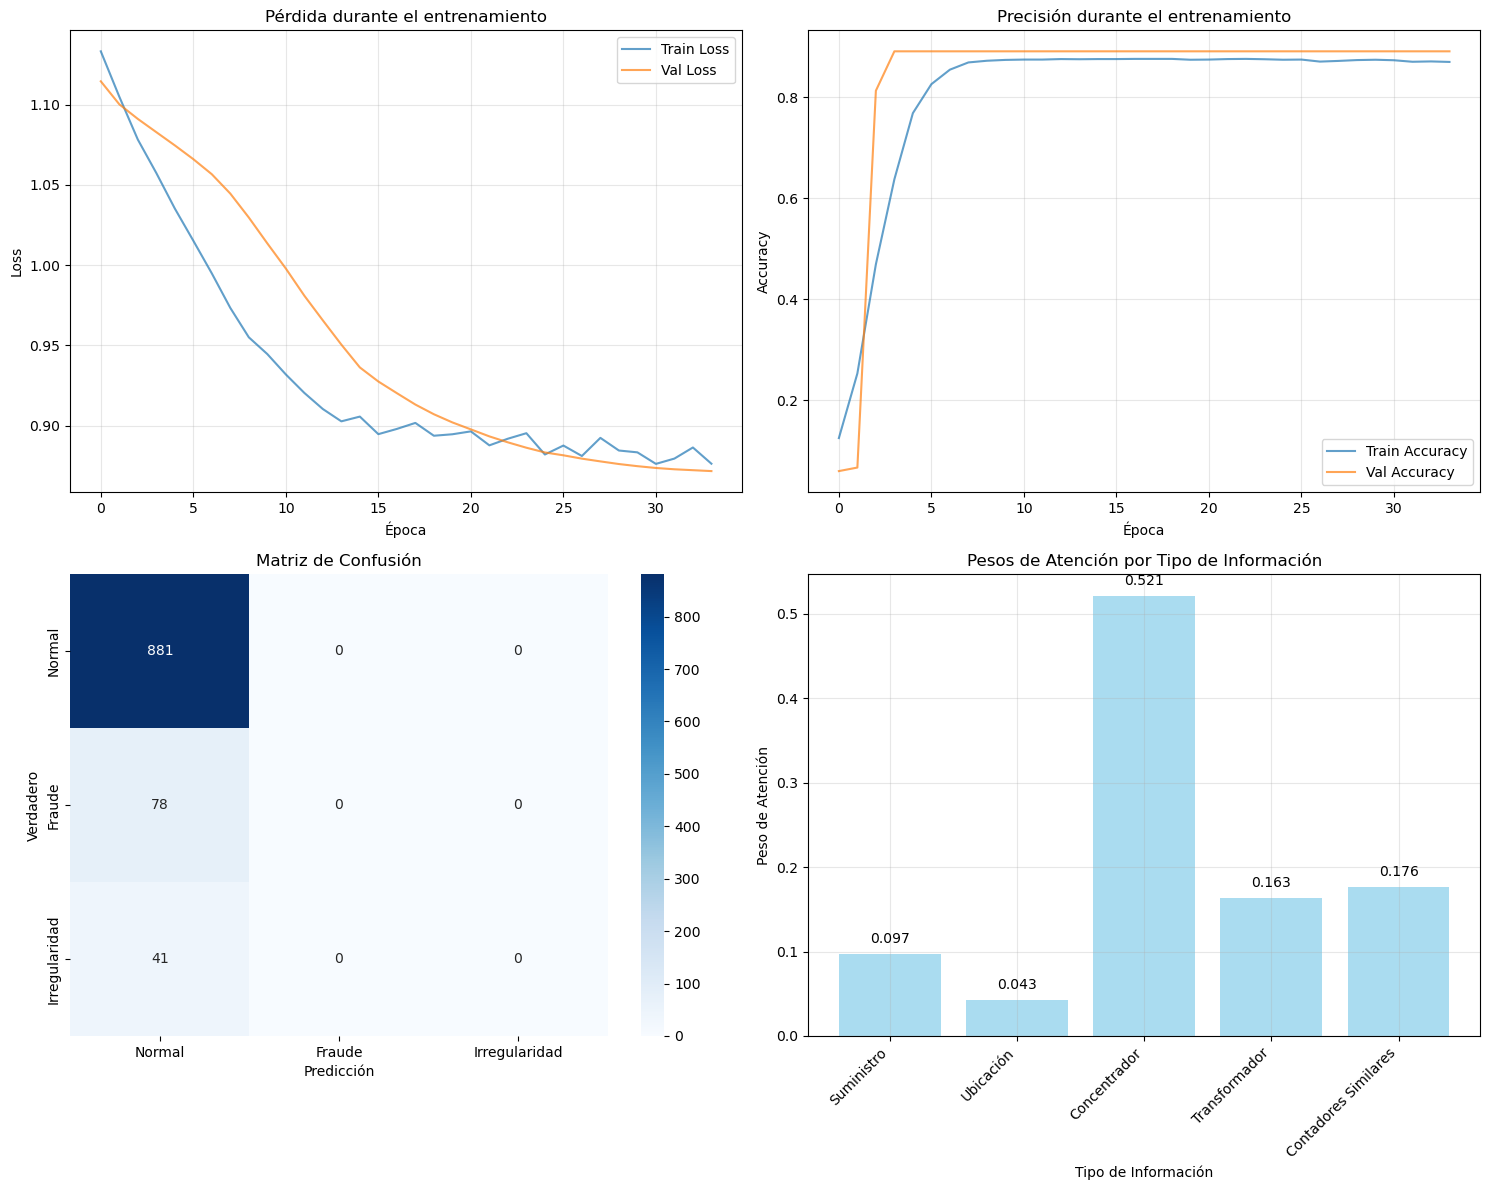

In [ ]:
# 6. Evaluar
logger.info("📊 Evaluando modelo...")
model.load_state_dict(torch.load('best_hetero_fraud_model.pth'))
evaluator = HeterogeneousEvaluator(model, device)

test_results = evaluator.evaluate_detailed(hetero_data, test_mask)
    
# 7. Analizar atención
attention_analysis = evaluator.analyze_attention_weights(hetero_data)
    
# 8. Mostrar resultados
logger.info("📈 RESULTADOS FINALES:")
logger.info(f"Mejor precisión de validación: {history['best_val_acc']:.4f}")
logger.info(f"ROC AUC: {test_results['roc_auc']:.4f}")
logger.info("\nReporte de clasificación:")
print(test_results['classification_report'])
    
logger.info("\nPesos de atención por tipo de información:")
for info_type, weight in attention_analysis.items():
    logger.info(f"  {info_type}: {weight:.3f}")
    
# 9. Visualizar resultados
plot_heterogeneous_results(history, test_results, attention_analysis)
    
#     # 10. Detectar fraudes potenciales
#     logger.info("🔍 Detectando fraudes potenciales...")
#     all_predictions = evaluator.predict(hetero_data)
#     all_probabilities = evaluator.predict_proba(hetero_data)
    
#     # Casos con alta probabilidad de fraude pero sin etiqueta
#     potential_frauds = []
#     for i in range(len(all_predictions)):
#         if hetero_data['contador'].y[i] == 0:  # Etiquetado como normal
#             fraud_prob = all_probabilities[i][1] + all_probabilities[i][2]
#             if fraud_prob > 0.8:  # Alta probabilidad de fraude
#                 potential_frauds.append({
#                     'contador_idx': i,
#                     'FRAUD_PROBABILITY_ADV': fraud_prob,
#                     'predicted_class': all_predictions[i],
#                     'node_id': raw_data['nodes']['contador'].iloc[i]['node_id']
#                 })
    
#     logger.info(f"Fraudes potenciales detectados: {len(potential_frauds)}")
    
#     return {
#         'model': model,
#         'history': history,
#         'test_results': test_results,
#         'attention_analysis': attention_analysis,
#         'potential_frauds': potential_frauds,
#         'hetero_data': hetero_data
#     }


## 5.8. Análisis avanzado del modelo

In [ ]:
# ==========================================
# 8. ANÁLISIS AVANZADO DEL MODELO
# ==========================================

class HeterogeneousModelAnalyzer:
    """Analizador avanzado para modelos heterogéneos"""
    
    def __init__(self, model, data, device='cpu'):
        self.model = model.to(device)
        self.data = data.to(device)
        self.device = device
        
    def analyze_node_importance(self, node_type='contador', top_k=10):
        """Analiza la importancia de nodos de un tipo específico"""
        
        self.model.eval()
        with torch.no_grad():
            # Obtener embeddings finales
            out = self.model(self.data.x_dict, self.data.edge_index_dict)
            
            if node_type == 'contador':
                node_embeddings = out
                node_labels = self.data['contador'].y
            else:
                # Para otros tipos de nodos, necesitaríamos extraer sus embeddings
                return None
            
            # Calcular importancia basada en la norma del embedding
            importance_scores = torch.norm(node_embeddings, dim=1)
            
            # Obtener top-k nodos más importantes
            top_indices = torch.topk(importance_scores, top_k).indices
            
            results = []
            for idx in top_indices:
                results.append({
                    'node_index': idx.item(),
                    'importance_score': importance_scores[idx].item(),
                    'predicted_class': node_embeddings[idx].argmax().item(),
                    'true_class': node_labels[idx].item() if node_labels is not None else None
                })
        
        return results
    
    def analyze_edge_importance(self, edge_type):
        """Analiza la importancia de diferentes tipos de edges"""
        
        # Implementación simplificada
        if edge_type in self.data.edge_index_dict:
            edge_index = self.data.edge_index_dict[edge_type]
            num_edges = edge_index.size(1)
            
            return {
                'edge_type': edge_type,
                'num_edges': num_edges,
                'source_nodes': edge_index[0].unique().size(0),
                'target_nodes': edge_index[1].unique().size(0),
                'avg_degree': num_edges / edge_index[0].unique().size(0) if edge_index[0].unique().size(0) > 0 else 0
            }
        
        return None
    
    def generate_fraud_risk_report(self, threshold=0.7):
        """Genera reporte de riesgo de fraude"""
        
        evaluator = HeterogeneousEvaluator(self.model, self.device)
        probabilities = evaluator.predict_proba(self.data)
        
        # Calcular scores de riesgo
        fraud_scores = probabilities[:, 1] + probabilities[:, 2]  # Fraude + Irregularidad
        
        high_risk_indices = np.where(fraud_scores > threshold)[0]
        
        report = {
            'total_contadores': len(probabilities),
            'high_risk_count': len(high_risk_indices),
            'high_risk_percentage': len(high_risk_indices) / len(probabilities) * 100,
            'average_fraud_score': np.mean(fraud_scores),
            'high_risk_nodes': []
        }
        
        for idx in high_risk_indices:
            report['high_risk_nodes'].append({
                'node_index': int(idx),
                'FRAUD_PROBABILITY_ADV': float(fraud_scores[idx]),
                'predicted_class': int(probabilities[idx].argmax()),
                'class_probabilities': probabilities[idx].tolist()
            })
        
        # Ordenar por probabilidad de fraude
        report['high_risk_nodes'].sort(key=lambda x: x['FRAUD_PROBABILITY_ADV'], reverse=True)
        
        return report

## 5.9. Ejecución final

In [15]:
if __name__ == "__main__":
    # Ejecutar pipeline heterogéneo
    torch.manual_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    
    print("🚀 INICIANDO MODELO GNN HETEROGÉNEO COMPLEJO")
    print("=" * 60)
    
    results = main_heterogeneous()
    
    print("\n" + "=" * 60)
    print("🎯 ENTRENAMIENTO HETEROGÉNEO COMPLETADO")
    print("=" * 60)
    print(f"📊 ROC AUC: {results['test_results']['roc_auc']:.4f}")
    print(f"🎯 Mejor Val Accuracy: {results['history']['best_val_acc']:.4f}")
    print(f"🔍 Fraudes potenciales: {len(results['potential_frauds'])}")
    print(f"💾 Modelo guardado en: best_hetero_fraud_model.pth")
    
    # Análisis adicional
    analyzer = HeterogeneousModelAnalyzer(results['model'], results['hetero_data'])
    
    # Analizar importancia de nodos
    important_nodes = analyzer.analyze_node_importance(top_k=5)
    print(f"\n🔝 Top 5 nodos más importantes:")
    for i, node in enumerate(important_nodes, 1):
        print(f"  {i}. Nodo {node['node_index']}: Score {node['importance_score']:.3f}")
    
    # Generar reporte de riesgo
    risk_report = analyzer.generate_fraud_risk_report(threshold=0.7)
    print(f"\n⚠️  Reporte de Riesgo:")
    print(f"  Total contadores: {risk_report['total_contadores']:,}")
    print(f"  Alto riesgo: {risk_report['high_risk_count']} ({risk_report['high_risk_percentage']:.1f}%)")
    print(f"  Score promedio: {risk_report['average_fraud_score']:.3f}")
    
    print("\n✅ ANÁLISIS COMPLETADO")

🚀 INICIANDO MODELO GNN HETEROGÉNEO COMPLEJO


NameError: name 'main_heterogeneous' is not defined